# Feature Evaluation and Modeling

This notebook investigates the quality of features from the bicycling and weather data (previously prepared in the data processing notebook) for use in regression models. It will also develop and compare regression models.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import pickle
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


In [2]:
with open("../../data/processed/encoded_data.pkl", 'rb') as handle:
    df = pickle.load(handle)

In [6]:
corr = df.corr()

In [7]:
corr.head()

,Fremont Bridge Total,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,apparentTemperatureMax,apparentTemperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,cloudCover,...,Month3,Month4,Month5,Month6,Month7,Month8,Month9,Month10,Month11,Month12
Fremont Bridge Total,1.000000,0.670992,0.343091,0.556740,-0.176747,0.667913,0.249994,0.537649,-0.180742,-0.475971,...,-0.106443,-0.004371,0.226714,0.216623,0.251883,0.216472,0.095485,-0.022634,-0.169409,-0.298922
apparentTemperatureHigh,0.670992,1.000000,0.413958,0.892981,-0.198179,0.998899,0.304672,0.889967,-0.196379,-0.513019,...,-0.149929,-0.030484,0.159857,0.250846,0.386337,0.391542,0.202486,-0.013185,-0.211051,-0.368686
apparentTemperatureHighTime,0.343091,0.413958,1.000000,0.399290,-0.091204,0.408896,0.671511,0.341417,-0.365065,-0.256258,...,-0.040111,0.039336,0.101080,0.145284,0.188867,0.169366,0.066170,-0.024272,-0.214237,-0.197896
apparentTemperatureLow,0.556740,0.892981,0.399290,1.000000,-0.118714,0.893454,0.304501,0.943692,-0.230098,-0.221920,...,-0.212090,-0.084849,0.122903,0.236651,0.347103,0.384521,0.247322,0.059887,-0.164509,-0.341897
apparentTemperatureLowTime,-0.176747,-0.198179,-0.091204,-0.118714,1.000000,-0.190962,-0.035337,-0.162995,0.054454,0.150097,...,0.016314,-0.045146,-0.082167,-0.094208,-0.083999,-0.037913,-0.041082,0.043907,0.079501,0.090202


In [24]:
high_corr = []
for column in corr.columns:
    for ind, val in enumerate(corr[column]):
        if np.abs(val) > 0.75 and np.abs(val) < 1:
            high_corr.append([ind, column])

In [25]:
rows = {}
for x in list(range(0, len(corr.columns))):
    rows[x] = corr.columns[x]

In [26]:
for each in high_corr:
    each[0] = rows[each[0]]

In [30]:
high_corr

[['apparentTemperatureLow', 'apparentTemperatureHigh'],
 ['apparentTemperatureMax', 'apparentTemperatureHigh'],
 ['apparentTemperatureMin', 'apparentTemperatureHigh'],
 ['dewPoint', 'apparentTemperatureHigh'],
 ['sunsetTime', 'apparentTemperatureHigh'],
 ['temperatureHigh', 'apparentTemperatureHigh'],
 ['temperatureLow', 'apparentTemperatureHigh'],
 ['temperatureMax', 'apparentTemperatureHigh'],
 ['temperatureMin', 'apparentTemperatureHigh'],
 ['uvIndex', 'apparentTemperatureHigh'],
 ['temperatureHighTime', 'apparentTemperatureHighTime'],
 ['apparentTemperatureHigh', 'apparentTemperatureLow'],
 ['apparentTemperatureMax', 'apparentTemperatureLow'],
 ['apparentTemperatureMin', 'apparentTemperatureLow'],
 ['dewPoint', 'apparentTemperatureLow'],
 ['temperatureHigh', 'apparentTemperatureLow'],
 ['temperatureLow', 'apparentTemperatureLow'],
 ['temperatureMax', 'apparentTemperatureLow'],
 ['temperatureMin', 'apparentTemperatureLow'],
 ['apparentTemperatureHigh', 'apparentTemperatureMax'],
 ['

Let's drop the "apparent" temperature columns and the temperature min/max columns (which seem to be almost the same as the temperature high/low columns).

In [3]:
for x in df.columns:
    if x.startswith("apparent"):
        df.drop(x, axis = 1, inplace = True)

In [4]:
df.drop(['temperatureMin', 'temperatureMax', 'temperatureMinTime', 'temperatureMaxTime'], axis = 1, inplace = True)

In [5]:
df.drop(['DayOfWeek', 'Month', 'precipType'], axis = 1, inplace = True)

In [6]:
df.columns

Index(['Date', 'Fremont Bridge Total', 'cloudCover', 'dewPoint', 'humidity',
       'moonPhase', 'precipIntensity', 'precipIntensityMax',
       'precipProbability', 'pressure', 'sunriseTime', 'sunsetTime',
       'temperatureHigh', 'temperatureHighTime', 'temperatureLow',
       'temperatureLowTime', 'uvIndex', 'uvIndexTime', 'visibility',
       'windBearing', 'windGust', 'windGustTime', 'windSpeed',
       'snowAccumulation', 'rain', 'snow', 'DoW1', 'DoW2', 'DoW3', 'DoW4',
       'DoW5', 'DoW6', 'Month2', 'Month3', 'Month4', 'Month5', 'Month6',
       'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12'],
      dtype='object')

## Modeling

First perform train/test split and scale data.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 2:], df['Fremont Bridge Total'], random_state = 2007)

In [8]:
SS = StandardScaler()
X_train_scaled = SS.fit_transform(X_train)
X_test_scaled = SS.transform(X_test)

Fit Ordinary Least Squares Linear Regression Model

In [53]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

In [58]:
ols.score(X_train, y_train)

0.8716281441122731

In [57]:
test_preds = ols.predict(X_test)

In [60]:
ols.coef_

array([-8.57531662e+02, -4.04997248e+00,  4.24485394e+02,  5.79431406e+01,
       -2.70173545e+04, -1.30326393e+03, -1.02800954e+03,  3.87034197e+00,
       -3.34059180e+00, -7.68556806e-01,  8.21611004e+01,  2.34874145e-01,
       -8.57513405e+00,  2.03059444e-01,  6.69683476e+01,  2.47412561e+00,
        4.75315729e+01,  4.33348538e-01, -3.63958155e+01, -3.09429303e-02,
        1.70953425e+02, -7.61276432e+01,  3.83965559e+02, -1.43553699e+03,
        4.53197559e+02,  4.26129756e+02,  2.33991195e+02, -4.29905858e+02,
       -3.15665582e+03, -3.38267036e+03, -2.57111008e+02, -1.30126916e+02,
        1.34382352e+02,  1.10735965e+03,  6.44721078e+02,  3.00687805e+02,
        1.90180716e+02,  2.88519841e+02,  3.99656614e+02,  8.93578998e+01,
       -6.22530041e+02])

In [61]:
resids = y_test - test_preds

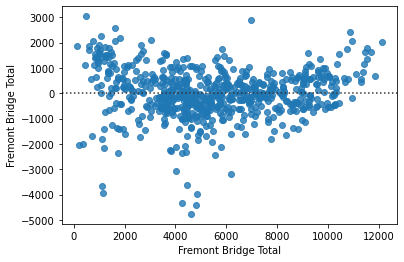

In [63]:
sns.residplot(y_test, resids);

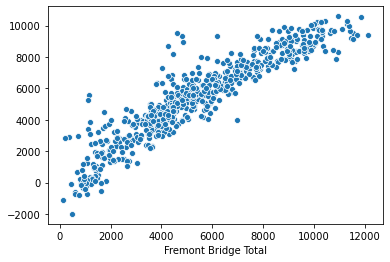

In [65]:
sns.scatterplot(x = y_test, y = test_preds);

Fit Ridge (L2) Regularized Linear Regression Model

In [66]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

In [69]:
ridge.score(X_train, y_train)

0.8699030412501301

In [30]:
def regression_modeler(X_train, X_test, y_train, y_test, model):
    reg = None
    if model == 'OLS':
        reg = LinearRegression()
    elif model == 'DecisionTree':
        reg = DecisionTreeRegressor()
    elif model == 'RandomForest':
        reg = RandomForestRegressor()
    elif model == 'KNN':
        reg = KNeighborsRegressor(n_neighbors = 10, weights = 'distance')
    else:
        print("Please provide a valid regressor model type")
    
    reg.fit(X_train, y_train)
    r2 = reg.score(X_test, y_test)
    test_preds = reg.predict(X_test)
    resids = y_test - test_preds
    
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    sns.residplot(y_test, resids, ax = ax[1], scatter_kws = {'alpha': 0.5})
    ax[1].set_title(f'{model}: Residual Plot')
    ax[1].set_xlabel('Expected Value')
    ax[1].set_ylabel('Residual Value')
    sns.scatterplot(x = y_test, y = test_preds, ax = ax[0], alpha = 0.5)
    ax[0].set_title(f'{model}: Predicted vs. Expected Value,\n R-squared = {round(r2, 2)}')
    ax[0].set_xlabel('Expected Value')
    ax[0].set_ylabel('Predicted Value')
    plt.tight_layout()
    plt.savefig(f"{model}_evalplots.png", dpi = 200);

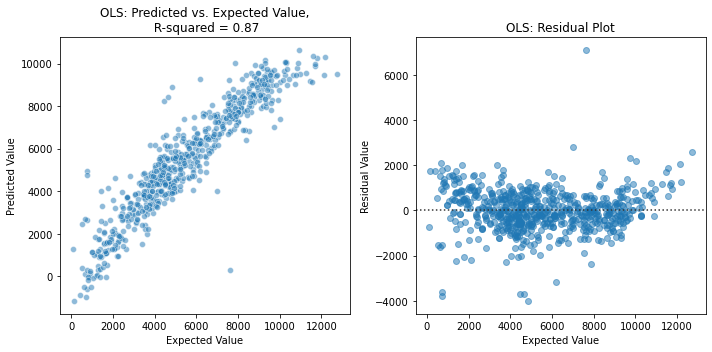

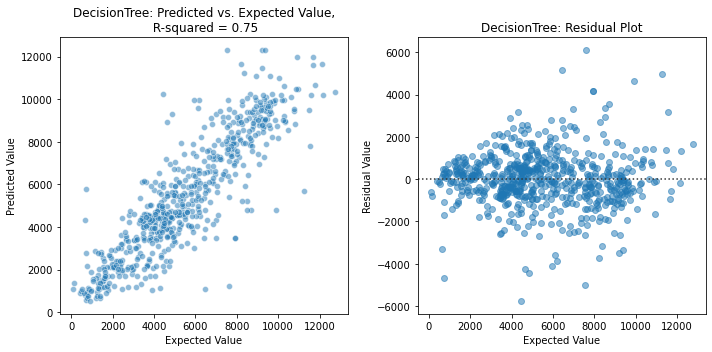

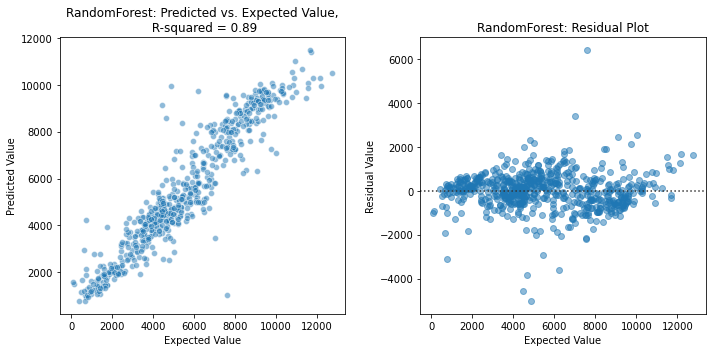

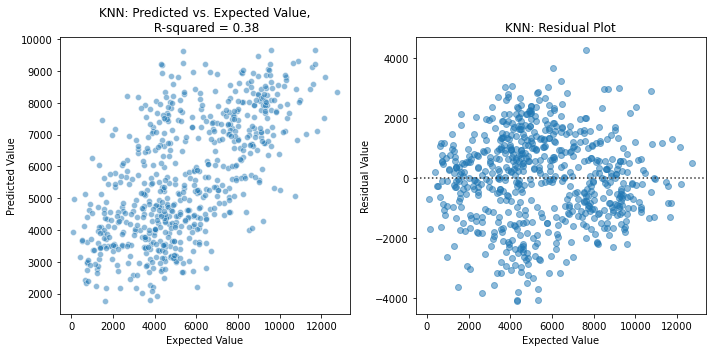

In [31]:
for x in ['OLS', 'DecisionTree', 'RandomForest', 'KNN']:
    regression_modeler(X_train, X_test, y_train, y_test, x)

In [32]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [42]:
feature_importances = {}
for ind, val in enumerate(X_train.columns):
    feature_importances.update({f"{val}": rf.feature_importances_[ind]})

In [46]:
a = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
for each in a:
    print(each)

('temperatureHigh', 0.459422443838191)
('DoW5', 0.1636531092313023)
('DoW6', 0.1555556640832419)
('precipProbability', 0.04935547863032364)
('cloudCover', 0.022060030323920506)
('precipIntensity', 0.016699985996990324)
('sunsetTime', 0.015474033023170991)
('sunriseTime', 0.014326937355405448)
('windSpeed', 0.010249656890382942)
('precipIntensityMax', 0.008349859915229777)
('uvIndex', 0.008178137147499884)
('humidity', 0.007190804697895523)
('DoW4', 0.006668755000816056)
('pressure', 0.005816479241763918)
('windBearing', 0.005744321742572046)
('windGustTime', 0.005493576806527044)
('visibility', 0.005228508564174353)
('uvIndexTime', 0.005139756928874138)
('temperatureLow', 0.005017253111318243)
('temperatureLowTime', 0.004772589079556236)
('windGust', 0.004532118524449035)
('temperatureHighTime', 0.004253747597489637)
('dewPoint', 0.0041415274336384185)
('moonPhase', 0.004057390764505276)
('Month5', 0.003534898091822397)
('snowAccumulation', 0.001125820680069321)
('DoW1', 0.000894517026